In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436601 entries, 0 to 436600
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            436601 non-null  int64  
 1   type            436601 non-null  object 
 2   amount          436601 non-null  float64
 3   nameOrig        436601 non-null  object 
 4   oldbalanceOrg   436601 non-null  float64
 5   newbalanceOrig  436601 non-null  float64
 6   nameDest        436600 non-null  object 
 7   oldbalanceDest  436600 non-null  float64
 8   newbalanceDest  436600 non-null  float64
 9   isFraud         436600 non-null  float64
 10  isFlaggedFraud  436600 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 36.6+ MB


<Axes: xlabel='type', ylabel='count'>

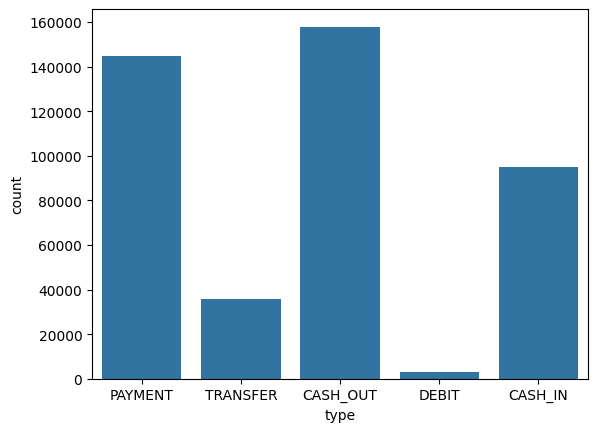

In [4]:
sns.countplot(x='type', data=data)

In [5]:
data['isFraud'].value_counts()

,count
isFraud,
0.0,436382
1.0,218


<Axes: >

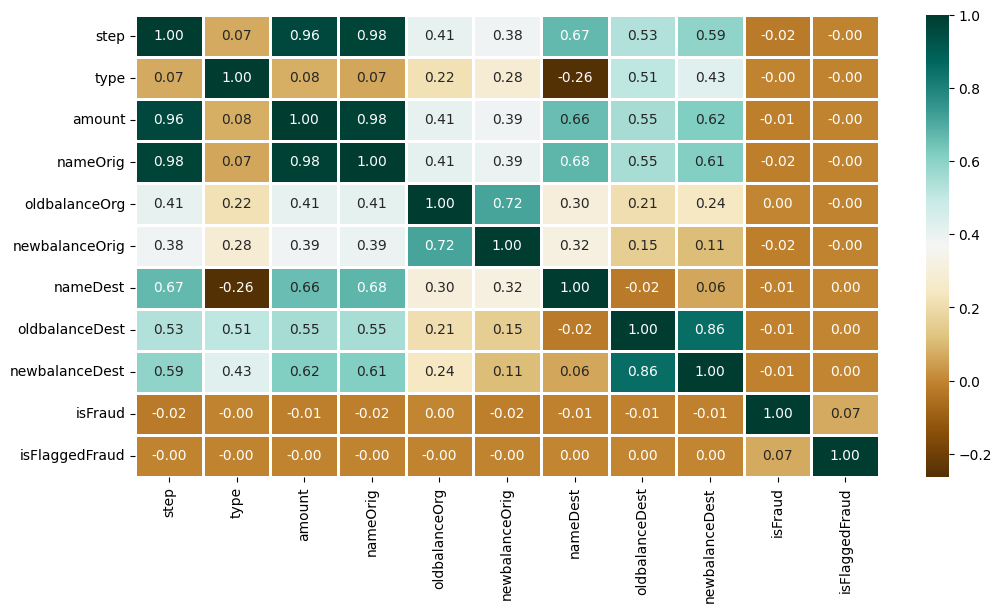

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.apply(lambda x: pd.factorize(x)[0]).corr(),
			cmap='BrBG',
			fmt='.2f',
			linewidths=2,
			annot=True)

In [7]:
type_new = pd.get_dummies(data['type'], drop_first=True)
data_new = pd.concat([data, type_new], axis=1)
data_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0,False,False,True,False
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0,False,False,True,False
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0,False,False,False,True
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0,True,False,False,False
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0,False,False,True,False


In [9]:
X = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = data_new['isFraud']
y

,isFraud
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0
...,...
436596,0.0
436597,0.0
436598,0.0
436599,0.0


In [19]:
type(y)

method

In [20]:
y = np.array(y)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [12]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [14]:
from xgboost import XGBClassifier

XGB = XGBClassifier()

In [22]:
from sklearn.model_selection import cross_val_score

y_cleaned = data_new['isFraud'].dropna().astype(int)

X_cleaned = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1).loc[y_cleaned.index]

result = cross_val_score(XGB, X_cleaned, y_cleaned)
print(f"Cross-validation scores: {result}")

Cross-validation scores: [0.86698351 0.99967934 0.99851122 0.99870591 0.99964498]


In [25]:
XGB = XGB.fit(X_cleaned, y_cleaned)
XGB


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [34]:
from sklearn.metrics import confusion_matrix

y_pred = XGB.predict(X_cleaned)

confusion = confusion_matrix(y_cleaned, y_pred)
confusion

array([[436382,      0],
       [    11,    207]])

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_cleaned, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    436382
           1       1.00      0.95      0.97       218

    accuracy                           1.00    436600
   macro avg       1.00      0.97      0.99    436600
weighted avg       1.00      1.00      1.00    436600



In [37]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_cleaned, y_pred)

np.float64(0.9747706422018348)